In [1]:
#-*- coding: utf-8 -*-

In [91]:
import requests 
import json
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import pickle
from selenium import webdriver
from selenium.webdriver.support.ui import Select
from selenium.common.exceptions import NoSuchElementException, UnexpectedAlertPresentException
from gensim.models import Word2Vec
import statsmodels.api as sm
from statsmodels.graphics import utils
from sklearn.cross_validation import cross_val_score, cross_val_predict, ShuffleSplit, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import nltk
from nltk.tokenize import sent_tokenize
from gensim.summarization import summarize

In [3]:
# 정규표현식으로 고쳐야 되는뎅... ;ㅅ;
def replacer(s):
    s = s.replace('\n', '').replace('\r', '').replace('\t', '')
    return s

In [4]:
# excel, pickle. db에 저장해야 하는뎅... ;ㅅ; 
def save(df, name):
    df.to_excel(name + ".xlsx")
    f = open(name + "_pickle.txt", 'w')
    pickle.dump(df, f)
    f.close()

In [5]:
BASE_URL = "http://store.steampowered.com"
CHART_BASE_URL = "http://steamcharts.com"
SPY_BASE_URL = "http://steamspy.com"

In [10]:
# 스팀차트에서 게임 리스트 크롤링 (세이브 해놓아서 이제 쓸일은 없는듯)
game_df = pd.DataFrame(columns=['name', 'link'])

for i in range(1, 10):
    steamchart_url = CHART_BASE_URL + "/top/p.{page_num}".format(page_num=i)
    response = requests.get(steamchart_url)
    dom = BeautifulSoup(response.content, 'html.parser')
    top_games_table = dom.select("table#top-games td.game-name.left")
    for top_game in top_games_table:
        name = replacer(top_game.select_one('a').text)
        link = top_game.select_one('a').attrs.get('href')
        game_df.loc[len(game_df)] = [name, link]

In [41]:
save(game_df, "game_df_old")

In [19]:
f = open("game_df_pickle.txt")
game_df = pickle.load(f)
f.close()

In [54]:
game_df

,name,link
0,Dota 2,/app/570
1,Counter-Strike: Global Offensive,/app/730
2,Team Fortress 2,/app/440
3,Sid Meier's Civilization V,/app/8930
4,Rust,/app/252490
5,ARK: Survival Evolved,/app/346110
6,Stardew Valley,/app/413150
7,Football Manager 2016,/app/378120
8,Garry's Mod,/app/4000
9,Rocket League,/app/252950


In [19]:
# 스팀차트에서 게임 플레이어 수 크롤링 (세이브 해놓아서 이제 쓸일은 없는듯2)
player_df = pd.DataFrame(columns=['last', 'median', 'mean'])

for i, row in game_df.iterrows():
    player_list = []
    steamchart_url = BASE_URL + row['link']
    response = requests.get(steamchart_url)
    dom = BeautifulSoup(response.content, 'html.parser')
    player_table = dom.select("div#content-wrapper td.right.num-f")
    for player in player_table:
        player_list.append(float(player.text))
    
    player_df.loc[len(player_df)] = [player_list[-1], np.median(player_list), np.mean(player_list)]


In [ ]:
save(player_df, "player_df")

In [20]:
f = open("player_df_pickle.txt")
player_df = pickle.load(f)
f.close()

In [27]:
driver = webdriver.Firefox()
weighted_tag_df = pd.DataFrame(columns=['name', 'tag', 'weight'])
game_tag_list = []
not_loaded_game = []
for i, row in game_df.iterrows():
    steam_url = BASE_URL + row['link']
    driver.get(steam_url)
    
    try:
        select_day = Select(driver.find_element_by_name('ageDay'))
        select_day.select_by_value('25')
        select_month = Select(driver.find_element_by_name('ageMonth'))
        select_month.select_by_value('February')
        select_year = Select(driver.find_element_by_name('ageYear'))
        select_year.select_by_value('1988')
        driver.find_element_by_css_selector("a.btnv6_blue_hoverfade.btn_small").click()
    except NoSuchElementException:
        pass
    
    tag_elements = driver.find_elements_by_css_selector("div.glance_tags.popular_tags a")
    tag_list = []
    i = len(tag_elements)
    for tag in tag_elements:
        tag_text = driver.execute_script("return arguments[0].innerHTML", tag)
        if(tag_text != u''):
            replaced_tag_text = replacer(tag_text)
            print(replaced_tag_text)
            weighted_tag_df.loc[len(weighted_tag_df)] = [row['name'], replaced_tag_text, i/len(tag_elements)]
            tag_list.append(replaced_tag_text)
            i -= 1
    if(tag_list != []):
        game_tag_list.append(tag_list)
    else:
        not_loaded_game.append(row['name'])
        game_df = game_df[game_df['name'] != row['name']]  

NameError: name 'game_df' is not defined

In [35]:
not_service_game = ['ARK: Survival Evolved',
'SMITE',
'Football Manager 2015',
'FINAL FANTASY XIV: A Realm Reborn',
'Path of Exile',
'Age of Empires II: HD Edition',
'Spacewar',
'Football Manager 2014',
'TERA',
'Counter-Strike Nexon: Zombies',
'Master of Orion',
'ArcheAge',
'Company of Heroes (New Steam Version)',
'Football Manager 2013',
'Football Manager 2012',
'Age of Mythology: Extended Edition',
'Rocksmith 2014',
'CABAL Online',
'MapleStory',
'FreeStyle2: Street Basketball',
'Dragon Age: Origins - Ultimate Edition']

In [34]:
game_tag_list

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],


In [35]:
weighted_tag_df

,name,tag,weight


In [23]:
model = Word2Vec(game_tag_list, window=5, min_count=5, size=100)

NameError: name 'game_tag_list' is not defined

In [72]:
print (model.syn0.shape)

(122L, 100L)


In [73]:
print (model[u'Strategy'])

[ 0.09203962  0.04510783  0.10730784 -0.06388637  0.04483759 -0.04783171
 -0.13938737  0.08750682 -0.06907009 -0.14695464 -0.07650381 -0.04949827
 -0.02643967  0.01267252 -0.130375    0.04487791 -0.0602975  -0.0261456
 -0.19665706  0.05134324 -0.07274029 -0.02233616 -0.1409606   0.2743223
 -0.09403681 -0.0432988   0.11476636  0.06123019 -0.05235332 -0.03411888
  0.11148679 -0.05974303  0.11401214  0.25221083 -0.2343884  -0.18571743
 -0.02766627 -0.10765514 -0.31933853  0.11458523  0.0633904  -0.02630725
 -0.16726591 -0.09121754 -0.0089567  -0.16095647  0.15206961  0.00952566
  0.06495027 -0.08878065  0.01962349  0.10105288  0.0398253  -0.11242212
  0.05627474 -0.07865559 -0.15072463 -0.11058834 -0.17187516  0.03310327
 -0.01310519 -0.11782493 -0.03914298 -0.04916824  0.0354878   0.0230182
 -0.09254121 -0.13632289  0.06471381  0.01411732 -0.09510358 -0.1225604
  0.04336205 -0.05908677 -0.13049965  0.17164274  0.0612965  -0.0157265
 -0.09528214  0.04123463 -0.16516349 -0.00354983  0.0934

In [77]:
model.most_similar(positive=[u'RPG'], topn=10)

[(u'Atmospheric', 0.9993453025817871),
 (u'Multiplayer', 0.999323308467865),
 (u'Action', 0.9993125200271606),
 (u'Simulation', 0.9992951154708862),
 (u'Singleplayer', 0.9992901086807251),
 (u'Online Co-Op', 0.9992725849151611),
 (u'Adventure', 0.9992412328720093),
 (u'Moddable', 0.9992401003837585),
 (u'Indie', 0.9992325305938721),
 (u'Great Soundtrack', 0.9992193579673767)]

In [78]:
model.most_similar(positive=['Open World','RPG'], negative=['Post-apocalyptic'], topn=10)

[(u'Sci-fi', 0.9974915981292725),
 (u'Online Co-Op', 0.9972966909408569),
 (u'Singleplayer', 0.9972550272941589),
 (u'Moddable', 0.9972319602966309),
 (u'Character Customization', 0.9972226023674011),
 (u'Great Soundtrack', 0.9971922039985657),
 (u'FPS', 0.9971805214881897),
 (u'Multiplayer', 0.9971762895584106),
 (u'Action', 0.997140645980835),
 (u'Atmospheric', 0.9971376061439514)]

In [79]:
model.most_similar(positive=['Open World','RPG'], topn=10)

[(u'Atmospheric', 0.9996486306190491),
 (u'Action', 0.9996254444122314),
 (u'Multiplayer', 0.9996200799942017),
 (u'Singleplayer', 0.9996023774147034),
 (u'Adventure', 0.9995899796485901),
 (u'Simulation', 0.9995710253715515),
 (u'Online Co-Op', 0.9995598793029785),
 (u'Great Soundtrack', 0.9995583295822144),
 (u'Indie', 0.999485433101654),
 (u'Moddable', 0.9994834065437317)]

In [ ]:
model.most_similar(positive=['Open World','RPG'], topn=10)

In [103]:
weighted_tag_df.ix[weighted_tag_df['tag'] == u'','tag'] = u'Early Access'

In [107]:
weighted_tag_df.ix[weighted_tag_df['tag'] == u'Early Access','name']

80                              Rust
325                         Unturned
385           H1Z1: King of the Kill
513                         Factorio
573                        Robocraft
633               H1Z1: Just Survive
653                             DayZ
853                       Brawlhalla
1033               Heroes & Generals
1108                   7 Days to Die
1188                 Space Engineers
1256      Don't Starve Together Beta
1588                  Portal Knights
1638                       Starbound
1658                      The Forest
1718                    Naval Action
1812                      Subnautica
2005                     Creativerse
2203                 Killing Floor 2
2323            Dungeon Defenders II
2557                       Hurtworld
2577                         Nosgoth
2597                 ShellShock Live
2806                  Scrap Mechanic
3013                           Squad
3195                    BeamNG.drive
3351                   Slime Rancher
3

In [108]:
save(weighted_tag_df, 'weighted_tag_df')

In [21]:
f = open("weighted_tag_df_pickle.txt")
weighted_tag_df = pickle.load(f)
f.close()

In [141]:
X = pd.DataFrame(columns=weighted_tag_df["tag"].unique())

In [142]:
X["name"] = game_df["name"]

In [143]:
for i, row in weighted_tag_df.iterrows():
    X[row["tag"]][X["name"] == row["name"]] = row["weight"]

In [144]:
X = X.fillna(0.)

In [145]:
X.describe().T.sort_values("mean", ascending=False)

,count,mean,std,min,25%,50%,75%,max
Multiplayer,204,0.542289,0.332458,0,0.25,0.650000,0.805882,1.000000
Action,204,0.517789,0.355913,0,0.20,0.577778,0.850000,1.000000
Singleplayer,204,0.364671,0.285099,0,0.10,0.300000,0.643908,0.900000
Adventure,204,0.320351,0.319938,0,0.00,0.232143,0.626645,1.000000
Open World,204,0.319224,0.381131,0,0.00,0.050000,0.700000,1.000000
Strategy,204,0.313403,0.378178,0,0.00,0.125000,0.600000,1.000000
Co-op,204,0.269331,0.303782,0,0.00,0.150000,0.500000,1.000000
RPG,204,0.250083,0.362918,0,0.00,0.000000,0.462500,1.000000
Simulation,204,0.241793,0.351960,0,0.00,0.000000,0.500000,1.000000
Free to Play,204,0.237843,0.414492,0,0.00,0.000000,0.200000,1.000000


In [73]:
save(X, 'X')

In [22]:
f = open("X_pickle.txt")
X = pickle.load(f)
f.close()

In [11]:
y = pd.read_excel('y.xlsx', 'Sheet1')
y = y[y.index.isin(X.index)]['last']

In [15]:
X = X.drop('name', axis=1)

In [120]:
X.describe()

,const,Free to Play,MOBA,Strategy,Multiplayer,Team-Based,Action,e-sports,Competitive,Online Co-Op,...,Movie,Dystopian,World War I,Visual Novel,Werewolves,Silent Protagonist,God Game,Arena Shooter,Parody,Match 3
count,204,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,...,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,1,0.237843,0.010539,0.313403,0.542289,0.081459,0.517789,0.017810,0.044168,0.127632,...,0.003119,0.008333,0.003354,0.002451,0.000980,0.001471,0.003676,0.003922,0.001961,0.003813
std,0,0.414492,0.096614,0.378178,0.332458,0.213391,0.355913,0.097499,0.155462,0.223786,...,0.044554,0.061019,0.047904,0.035007,0.014003,0.021004,0.052511,0.056011,0.028006,0.054455
min,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1,0.000000,0.000000,0.000000,0.250000,0.000000,0.200000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1,0.000000,0.000000,0.125000,0.650000,0.000000,0.577778,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1,0.200000,0.000000,0.600000,0.805882,0.000000,0.850000,0.000000,0.000000,0.212500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1,1.000000,1.000000,1.000000,1.000000,0.800000,1.000000,0.700000,0.933333,0.950000,...,0.636364,0.550000,0.684211,0.500000,0.200000,0.300000,0.750000,0.800000,0.400000,0.777778


In [121]:
model = LinearRegression()
cross_val_score(model, X, y, cv=3)

array([ -1.11594862e+21,  -1.07411559e+01,  -2.94474670e+02])

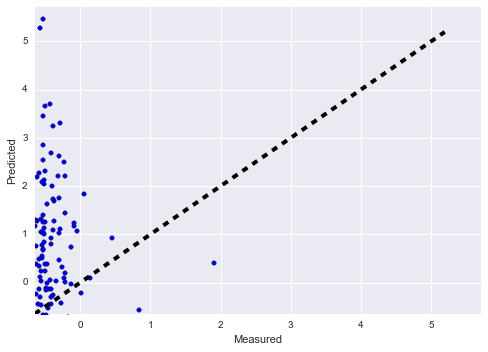

In [122]:
predicted = cross_val_predict(model, X, y, cv=3)

fig, ax = plt.subplots()
ax.scatter(y, predicted)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.xlim(y.min(), y.max()*1.1)
plt.ylim(y.min(), y.max()*1.1)
plt.show()

In [89]:
for row in X.itertuples(index=False):
    print(sum(row[:-1]))

11.5
11.5
11.5
11.5
11.5
11.5
6.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.0
9.5
11.5
11.5
11.5
11.5
5.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
9.0
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
5.5
11.5
11.5
7.5
11.5
11.5
11.5
7.0
11.5
11.5
10.0
11.5
11.5
11.5
11.5
6.5
2.5
11.5
11.5
11.5
8.5
11.5
9.5
11.5
11.5
11.5
11.5
8.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
10.0
11.5
6.5
8.0
11.5
9.5
10.0
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
10.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
7.5
11.5
3.5
11.5
10.5
11.5
11.5
11.5
11.5
11.5
11.5
6.0
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
10.5
6.0
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
11.5
9.5
11.5
11.0
5.0
11.5
11.5
11.5
9.5
11.5
7.0
2.0
11.5
9.0
8.5
11.5
11.0
11.5
6.5
11.5
9.5
11.5
11.5
9.0
11.5
6.5
11.5
11.5
8.5
10.0
11.5
11.5
11.5
11.5
11.5
9.0
11.5
11.5
10.5
5.22222222222
11.5


In [7]:
driver = webdriver.Firefox()
game_top_review_list = pd.DataFrame(columns=["game_name", "sentence"])
for i, row in game_df.iterrows():
    steam_url = BASE_URL + row["link"]
    driver.get(steam_url)
    
    try:
        select_day = Select(driver.find_element_by_name('ageDay'))
        select_day.select_by_value('25')
        select_month = Select(driver.find_element_by_name('ageMonth'))
        select_month.select_by_value('February')
        select_year = Select(driver.find_element_by_name('ageYear'))
        select_year.select_by_value('1988')
        driver.find_element_by_css_selector("a.btnv6_blue_hoverfade.btn_small").click()
    except NoSuchElementException:
        pass
    
    review_elements = driver.find_elements_by_css_selector("div#Reviewsall0 div.content")
    review_sentence_list = []
    for review in review_elements:
        if(review.get_attribute('innerHTML') != u''):
            sentence = []
            for i, row in review.get_attribute('innerHTML'):
                words = str(row).split()
                sentence.append( words )
            review_sentence_list.append(sentence)

In [13]:
review_sentence_test = review_test[0].find_all(text=True)

In [21]:
replacer(review_sentence_test[-1]) == u''

True

In [26]:
driver = webdriver.Firefox()

driver.get("http://steamcommunity.com/app/570/reviews/?browsefilter=toprated&filterLanguage=english")

try:
    select_day = Select(driver.find_element_by_name('ageDay'))
    select_day.select_by_value('25')
    select_month = Select(driver.find_element_by_name('ageMonth'))
    select_month.select_by_value('February')
    select_year = Select(driver.find_element_by_name('ageYear'))
    select_year.select_by_value('1988')
    driver.find_element_by_css_selector("a.btnv6_blue_hoverfade.btn_small").click()
except NoSuchElementException:
    pass

review_elements = driver.find_elements_by_css_selector("div.apphub_CardTextContent")
#review_elements[0].text
review_sentence_list = []
for review in review_elements:
    if(review.text != u''):
        sentence = []
        words = review.text.split()
        review_sentence_list.append( words )
        #review_sentence_list.append(sentence)
        #print(words)


In [10]:
driver.quit()

In [85]:
docs = ""

for i in range(1, 10):
    steam_review_url = """http://steamcommunity.com/app/570/homecontent/?userreviewsoffset={offset_num}&p={page_num}
    &appHubSubSection=10&browsefilter=toprated&filterLanguage=english&searchText=""".format(offset_num=10*(i-1), page_num=i)
    response = requests.get(steam_review_url)
    dom = BeautifulSoup(response.content, 'html.parser')
    reviews_table = dom.select("div.apphub_CardTextContent")
    #reviews_table[0].text.split()
    for review in reviews_table:
        docs += "\n" + review.text

In [86]:
tokens = nltk.word_tokenize(docs)

In [93]:
tokens

[u'Posted',
 u':',
 u'13',
 u'November',
 u',',
 u'2014',
 u'This',
 u'game',
 u'taught',
 u'me',
 u'about',
 u'the',
 u'diversity',
 u'of',
 u'cultures',
 u'that',
 u'our',
 u'small',
 u'little',
 u'corner',
 u'of',
 u'the',
 u'universe',
 u'offers.Then',
 u'it',
 u'taught',
 u'me',
 u'to',
 u'hate',
 u'them',
 u'all',
 u'.',
 u'Posted',
 u':',
 u'27',
 u'September',
 u',',
 u'2014',
 u'Side',
 u'effects',
 u'include',
 u':',
 u'-Hatred',
 u'of',
 u'other',
 u'humans-Lack',
 u'of',
 u'trust',
 u'in',
 u'others-Carpal',
 u'Tunnel-Improved',
 u'hand',
 u'eye',
 u'coordination-A',
 u'large',
 u'ego-Weight',
 u'gain-Weight',
 u'loss-Confidence-Despression-Extreme',
 u'Racism-EXTREME',
 u'RACISM-Increased',
 u'strategic',
 u'thinking',
 u'capabilities-Mushy-brain',
 u'syndrome-Subconsciously',
 u'learning',
 u'a',
 u'new',
 u'language-Subconsciously',
 u'learning',
 u'to',
 u'hate',
 u'the',
 u'culture',
 u'of',
 u'said',
 u'language-Literally',
 u'every',
 u'ailment',
 u'that',
 u'is',
 u

In [87]:
test_text = nltk.Text(tokens, name='NMSC')

In [88]:
print(test_text)
print(len(test_text.tokens))
print(len(set(test_text.tokens)))
print(test_text.vocab().most_common(10))

<Text: NMSC>
9085
2392
[(u',', 415), (u'.', 318), (u'the', 229), (u'to', 198), (u'and', 181), (u'I', 156), (u'a', 135), (u'you', 135), (u'of', 121), (u':', 120)]


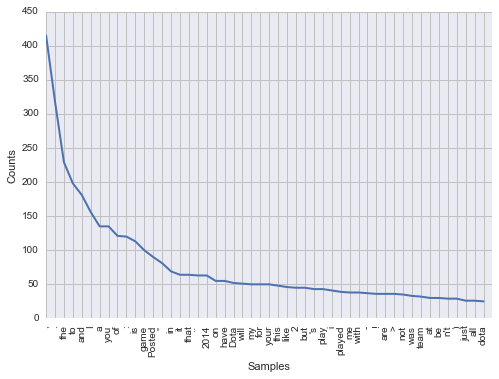

In [89]:
test_text.plot(50)

In [90]:
test_text.collocations()

played DotaI; play dota; many people; played Dota; learning curve;
played Dotanow; like humans.-Bots; Murderer trees2-; South Americans;
apparent reason5-; can:1- Murderer; creature chilling; develop
erectile; erectile dysfunction; extended seated; single match4-; Death
Prophet; NPC creeps; cheese3- Learn; movement speed


In [123]:
#docs = ""
total_tokens = []
user_review_list = []

for i in range(1, 100):
    steam_review_url = """http://steamcommunity.com/app/394510/homecontent/?userreviewsoffset={offset_num}&p={page_num}
    &appHubSubSection=10&browsefilter=toprated&filterLanguage=english&searchText=""".format(offset_num=10*(i-1), page_num=i)
    response = requests.get(steam_review_url)
    dom = BeautifulSoup(response.content, 'html.parser')
    reviews_table = dom.select("div.apphub_CardTextContent")
    for review in reviews_table:
        #docs += "\n" + review.text
        tokens = nltk.word_tokenize(review.text)
        tokens[0:6] = []
        clean_tokens = []
        for word in tokens:
            word = word.lower()
            if word.isalpha(): # drop all non-words
                clean_tokens.append(word)
        total_tokens += clean_tokens        
        user_review_list.append(clean_tokens)

In [61]:
user_review_list

[[u'Posted',
  u':',
  u'16',
  u'February',
  u'The',
  u'barrel',
  u'of',
  u'the',
  u'soldier',
  u"'s",
  u'gun',
  u'is',
  u'IN',
  u'the',
  u'Sectoid',
  u"'s",
  u'MOUTH.65',
  u'%',
  u'chance',
  u'to',
  u'hit.Your',
  u'hit-chance',
  u'is',
  u'above',
  u'75',
  u'%',
  u'.Guaranteed',
  u'miss.The',
  u'Stun',
  u'Lancer',
  u'is',
  u'30',
  u'tiles',
  u'away.It',
  u'sprints',
  u'to',
  u'your',
  u'squad',
  u',',
  u'incapacitates',
  u'one',
  u'soldier',
  u',',
  u'nearly',
  u'killing',
  u'them',
  u'in',
  u'the',
  u'process',
  u',',
  u'and',
  u'panics',
  u'two',
  u'others',
  u'.',
  u'Both',
  u'panicked',
  u'soldiers',
  u'throw',
  u'grenades',
  u'at',
  u'their',
  u'own',
  u'feet.A',
  u'Viper',
  u'is',
  u'15',
  u'tiles',
  u'away',
  u'.',
  u'Will',
  u'it',
  u'use',
  u'its',
  u'long-range',
  u'grab',
  u'or',
  u'will',
  u'it',
  u'use',
  u'its',
  u'long-range',
  u'poison',
  u'AoE',
  u'?',
  u'Trick',
  u'question',
  u'.',
 

In [76]:
model = Word2Vec(user_review_list, window=5, min_count=5, size=100)

In [124]:
test_text = nltk.Text(total_tokens, name='NMSC')

In [125]:
print(test_text)
print(len(test_text.tokens))
print(len(set(test_text.tokens)))
print(test_text.vocab().most_common(10))

<Text: NMSC>
80318
6840
[(u'the', 3883), (u'and', 2372), (u'to', 2170), (u'a', 2138), (u'you', 1891), (u'of', 1664), (u'is', 1450), (u'game', 1437), (u'it', 1349), (u'i', 1178)]


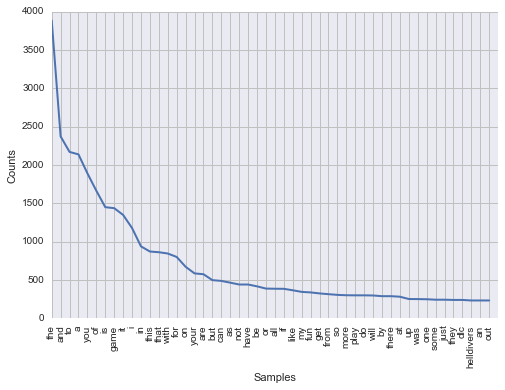

In [126]:
test_text.plot(50)

In [127]:
test_text.collocations()

starship troopers; super earth; friendly fire; twin stick; alien
swarm; stick shooter; deluxe edition; research points; digital deluxe;
helluva way; drop pod; stick shooters; procedurally generated;
negative reviews; base game; long time; great game; gory gory; unfair
advantage; managed democracy


In [7]:
driver = webdriver.Firefox()
reviewer_df = pd.DataFrame(columns=['game_name', 'reviewer', 'reviewer_link'])
reviewer_list = []
for i, row in game_df.iterrows():
    steam_url = BASE_URL + row['link']
    driver.get(steam_url)
    
    try:
        select_day = Select(driver.find_element_by_name('ageDay'))
        select_day.select_by_value('25')
        select_month = Select(driver.find_element_by_name('ageMonth'))
        select_month.select_by_value('February')
        select_year = Select(driver.find_element_by_name('ageYear'))
        select_year.select_by_value('1988')
        driver.find_element_by_css_selector("a.btnv6_blue_hoverfade.btn_small").click()
    except NoSuchElementException:
        pass

    onegame_reviewer_list = []
    reviewer_elements = driver.find_elements_by_css_selector("div#Reviewsall0 div.persona_name a")
    for reviewer_element in reviewer_elements:
        reviewer_name = reviewer_element.text
        reviewer_link = reviewer_element.get_attribute('href')
        print(reviewer_name, reviewer_link)
        onegame_reviewer_list.append(reviewer_name)
        reviewer_df.loc[len(reviewer_df)] = [row['name'], reviewer_name, reviewer_link]
        #print(reviewer.text)
    reviewer_list.append(onegame_reviewer_list)
driver.quit()

RevyHuang http://steamcommunity.com/id/revyhuang/
VPiGFx http://steamcommunity.com/profiles/76561198245178862/
Mikewell http://steamcommunity.com/id/mikewell/
EterNity http://steamcommunity.com/id/eternitydia/
potato http://steamcommunity.com/profiles/76561198120907290/
Forsaken Legendary Dan http://steamcommunity.com/id/DraganMKD87/
Cecilia http://steamcommunity.com/id/IsabellaDs/
✯Lucky✯ http://steamcommunity.com/id/thisguyisdope/
Artaxeus http://steamcommunity.com/id/Artaxeus/
Ahrigato fox http://steamcommunity.com/id/CpJenkaz/
Chilgoatty http://steamcommunity.com/id/iamseanliu/
Okihara Jones http://steamcommunity.com/id/okiharajones/
Wild_Piggie http://steamcommunity.com/id/wildpiggie/
= SirRabies = http://steamcommunity.com/id/sirrabies/
ServerNotFound http://steamcommunity.com/id/ServerNotFound/
Shank ur Nan http://steamcommunity.com/profiles/76561198011645486/
Haxxson Jackson http://steamcommunity.com/id/appleducks/
Dyrd the Doppler http://steamcommunity.com/profiles/76561198109

In [35]:
save(reviewer_df, 'reviewer_df')
f = open("reviewer_list_pickle.txt", 'w')
pickle.dump(reviewer_list, f)
f.close()

In [6]:
f = open("reviewer_df_pickle.txt")
reviewer_df = pickle.load(f)
f.close()

In [7]:
f = open("reviewer_list_pickle.txt")
reviewer_list = pickle.load(f)
f.close()

In [12]:
driver = webdriver.Firefox()

owner_df = pd.DataFrame(columns=['name', 'game'])
owner_list = []

for i, row in reviewer_df.iterrows():
    try:
        driver.get(row['reviewer_link'] + "games/?tab=all")
        game_elements = driver.find_elements_by_css_selector("div#games_list_rows div.gameListRowItemName.ellipsis ")
        one_owner_list = []
        for game_element in game_elements[:5]:
            game = game_element.text
            one_owner_list.append(game)
            #print(game)
            owner_df.loc[len(owner_df)] = [row['reviewer'], game]
        #if(one_owner_list == []):
        owner_list.append(one_owner_list)
        print(row['reviewer'])
    except UnexpectedAlertPresentException:
        pass
driver.quit()  

RevyHuang
VPiGFx
Mikewell
EterNity
potato
Forsaken Legendary Dan
Cecilia
✯Lucky✯
Artaxeus
Ahrigato fox
Chilgoatty
Okihara Jones
Wild_Piggie
= SirRabies =
ServerNotFound
Shank ur Nan
Haxxson Jackson
Dyrd the Doppler
kruna
SomeHurt
TeT
❖ The Guardian ♛
Edgy Mc аутизм
M4uZi ツ
Dr. n♂n-ejac. O
♥♥ErickaUnlimited♥♥
Stardew Pancake
Zhev
Rachuu
Connor McGrogol
Keiriel Solin
Vandelay
MuskyFox
Koopa Troopa 64
Great Empedocles
Mr. Barker
[AG] kyle13202
Jacob_MasterRace
Slymadness
fouru
tefive
ezwip
Nexiu
[MLM] MeingroessterFan
Rick Sanchez [C137]
Minyel
gally
Nemesis
Arctic
El Oshcuro
-Farmazone
CuppaBro
Velka
Rook
MorbidDonkey
JCC
The Railroad King
Gunsofglory
Lazyless
emmi
StavenMG
Bjhhjh
Kydoimos
Hypah™ @NoSleep
RagingAlpaca
TheGrandMaster®
TeamTom
Chester Bueno
Black Rainbow
pointlessnumbers
% // RXX
yukisnow78
Pi
skare708
Slurk
Wabuilderman
Perastis köpeği
Mira
Liamaru
Pyxis
ShadowKnight332
Mr Mumble
herbertken
Deus Vult
Luwbe
RUSE Building my PC in 1 week!
Pepi Varit Här
ASmallLoanOfAMillion

In [13]:
len(owner_list)

1018

In [17]:
owner_df.tail(25)

,name,game
4484,Animal,Killing Floor
4485,Animal,Arma 2: Free
4486,Animal,Counter-Strike: Global Offensive
4487,Animal,No More Room in Hell
4488,Animal,Counter-Strike: Source
4489,Taylor,Killing Floor
4490,Taylor,Killing Floor 2
4491,Taylor,Team Fortress 2
4492,Taylor,Terraria
4493,Taylor,Left 4 Dead 2


In [14]:
save(owner_df, 'owner_df')
f = open("owner_list_pickle.txt", 'w')
pickle.dump(owner_list, f)
f.close()

In [ ]:
http://steamcommunity.com/id/meningate/games/?tab=all

In [10]:
driver = webdriver.Firefox()
try:
    driver.get("http://store.steampowered.com/app/109600/")
    reviewer_elements = driver.find_elements_by_css_selector("div#Reviewsall0 div.persona_name a")
    reviewer_name = reviewer_elements[2].text
except UnexpectedAlertPresentException:
    pass

In [18]:
reviewer_name

u'steveb315'

In [26]:
reviewer_df.ix[452]['reviewer'] = reviewer_name

In [20]:
reviewer_df.ix[452]['reviewer']

u'steveb315'

In [31]:
reviewer_list[90][2] = reviewer_name

In [32]:
reviewer_list[90][2]

u'steveb315'